# Prudential life insurance      
데이터셋 - Kaggle      
형태 - 파일데이터(csv)       
다운로드 - https://www.kaggle.com/c/prudential-life-insurance-assessment      

# 1. Introduction

미국 최대의 생명 보험회사 푸르덴셜에서 5년전 제공한 데이터 셋입니다. 이 데이터 세트에는 생명 보험 신청자의 속성을 설명하는 100 개 이상의 변수가 제공됩니다. 테스트 세트의 각 ID에 대한 "Response"변수를 예측하는 것입니다. "Response"은 8 단계의 위험 분류 입니다.

생명보험 청약 프로세스는 평균 30 일 이내에 건강 검진을 포함하여 위험 분류 및 적격성을 식별하기 위해 광범위한 정보를 바탕으로 진행됩니다. 이러한 이유로 미국 가구의 40 %만이 개인 생명 보험을 소유하고 있습니다. 푸르덴셜은 신규 및 기존 고객이 프라이버시 경계를 유지하면서 청약 프로세스를 신속하고 비용 효과적으로 만들고자 합니다. 

향상된 자동화 방식을 사용하여 위험을 정확하게 분류하는 예측 모델을 개발함으로써 업계에 대한 대중의 인식에 큰 영향을 미칠 수 있을 것입니다. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['figure.figsize'] = (10, 7)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%matplotlib inline 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
filename = '/content/sample_data/train.csv'
train = pd.read_csv(filename)

In [4]:
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.08,2,1,1,0.64,0.58,0.15,0.32,0.03,12,1,0.00,3,nan,1,2,6,3,1,2,1,1,1,3,1,0.00,1,1,2,2,nan,0.60,nan,0.53,4.00,112,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.08,2,3,1,0.06,0.60,0.13,0.27,0.00,1,3,0.00,2,0.00,1,2,6,3,1,2,1,2,1,3,1,0.00,1,3,2,2,0.19,nan,0.08,nan,5.00,412,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.08,2,3,1,0.03,0.75,0.29,0.43,0.03,9,1,0.00,2,0.03,1,2,8,3,1,1,1,2,1,1,3,nan,3,2,3,3,0.30,nan,0.23,nan,10.00,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.49,2,3,1,0.16,0.67,0.21,0.35,0.04,9,1,0.00,3,0.20,2,2,8,3,1,2,1,2,1,1,3,nan,3,2,3,3,0.42,nan,0.35,nan,0.00,350,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.23,2,3,1,0.42,0.65,0.23,0.42,0.03,9,1,0.00,2,0.05,1,2,6,3,1,2,1,2,1,1,3,nan,3,2,3,2,0.46,nan,0.41,nan,nan,162,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


#2. Data
 데이터는 Train : Test = 3 : 1 비율로 분리되고 무작위 샘플링으로 이루어진다. Train data는 59,766명, 126개 변수로 구성된 transactional data(low level)이고 , Test data는 19,766명, 126개 변수로 구성된다. 변수의 범주는 다음과 같다. 
  * **Product Information** 보험상품 : Info_1 ~ Info_7
  * **Insurance Age** 보험나이 
  * **Height** 키
  * **Weight** 몸무게
  * **BMI** 체질량 지수 
  * **Employment Information** 고용정보 : Info_1 ~ Info_6
  * **Insured Information** 보험정보 : Info_1 ~ Info_7
  * **Insurance History** 보험내역 : Info_1 ~ Info_9
  * **Family History** 가족력 : Info_1 ~ Info_5
  * **Medical History** 기왕력 : Info_1 ~ Info_41
  * **Medical Keyword** 메디컬 키워드 : Info_1 ~ Info_48 

각 범주에는 class 별 여러 변수가 포함되어 있다. 

In [5]:
train.columns

Index(['Id', 'Product_Info_1', 'Product_Info_2', 'Product_Info_3',
       'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7',
       'Ins_Age', 'Ht',
       ...
       'Medical_Keyword_40', 'Medical_Keyword_41', 'Medical_Keyword_42',
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Response'],
      dtype='object', length=128)

#3. Exploratory Data Analysis

In [6]:
df = pd.DataFrame(["Product Information",
"Insurance Age",
"Height",
"Weight", 
"BMI",
"Employment Information",
"Insured Information",
"Insurance History",
"Family History",
"Medical History",
"Medical Keyword"], columns = ['Variable_type'])

df['Continous'] = [1,1,1,1,1,3,0,1,4,0,0]
df['Categorical'] = [6,0,0,0,0,3,7,8,1,4,0]
df['Dummy'] = [0,0,0,0,0,0,0,0,0,0,48]
df['Total'] = df.iloc[:, 1:4].sum(axis=1)
#df['Total'] = df['Continous'] + df['Categorical'] + df['Dummy']
#df['Total']= df.sum(axis=1)
#df = df.append({'Variable_type':'Sum','Continous': 13, 'Categorical':66, 'Dummy':48, 'Total':1}, ignore_index=True) 
# cloumns 합을 값으로 하는 row 만들기

* 변수의 유형        
 Continuous, Categorical(명목형 및 순서형) 변수와 Dummy(이진형/지표형) 변수의 유형을 파악한다. 이과정은 모델링 과정에서 변수 선택 및 알고리즘의 선택에 도움이 된다.

 Continous 변수는 요약 통계량, 막대 그래프 및 밀도분포표를 사용하여 분석한다. 범주형 변수는 변수에 따른 결과를 추적하기 위하여 사건 발생률 차트를 사용하여 분석한다.     
  

In [7]:
df

,Variable_type,Continous,Categorical,Dummy,Total
0,Product Information,1,6,0,7
1,Insurance Age,1,0,0,1
2,Height,1,0,0,1
3,Weight,1,0,0,1
4,BMI,1,0,0,1
5,Employment Information,3,3,0,6
6,Insured Information,0,7,0,7
7,Insurance History,1,8,0,9
8,Family History,4,1,0,5
9,Medical History,0,4,0,4


* 반응도 히스토그램               
 명목형 변수인 고객의 위험분류 1~8등급에 따른 반응 도표이다. 위험등급이 위험도 규모의 크기 순서인지 여부는 언급되지 않았으나, 응답 변수의 분포를 통해 8등급이 가장 낮은 위험도를 나타내는 것으로 유추할 수 있다. 

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


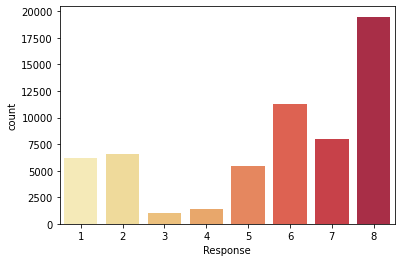

In [8]:
sns.countplot(data = train, x = 'Response', alpha=0.9, palette='YlOrRd')

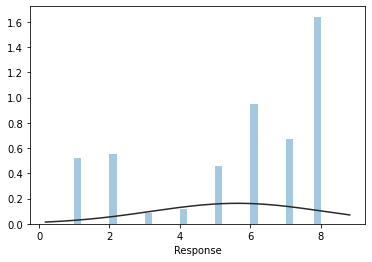

In [9]:
from scipy.stats import norm
ax = sns.distplot(train['Response'], fit=norm, kde=False)

* 요약통계          
기계 학습 알고리즘 변수의 보다 쉬운 통합을 위해 [0, 1] 범위로 정규화한다. 요약 통계량은 기본 데이터 분포를 이해하고, box plot 및 density plot 을 통해 데이터를 시각화하는 데 도움이 된다.

In [10]:
con = train.loc[:,['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI']]
con1 = train.loc[:,['Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6']]

In [11]:
con.describe()

,Product_Info_4,Ins_Age,Ht,Wt,BMI
count,59381.00,59381.00,59381.00,59381.00,59381.00
mean,0.33,0.41,0.71,0.29,0.47
std,0.28,0.20,0.07,0.09,0.12
min,0.00,0.00,0.00,0.00,0.00
25%,0.08,0.24,0.65,0.23,0.39
50%,0.23,0.40,0.71,0.29,0.45
75%,0.49,0.57,0.76,0.35,0.53
max,1.00,1.00,1.00,1.00,1.00


* 연속 변수 분석   

> Box plot 을 사용하면 특히 특이치와 관련하여 데이터 세트를 시각화할 수 있다.

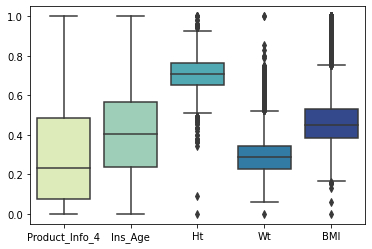

In [12]:
sns.boxplot(data = con, palette='YlGnBu')

* 요약통계   

In [13]:
con1.describe()

,Employment_Info_1,Employment_Info_4,Employment_Info_6
count,59362.00,52602.00,48527.00
mean,0.08,0.01,0.36
std,0.08,0.03,0.35
min,0.00,0.00,0.00
25%,0.04,0.00,0.06
50%,0.06,0.00,0.25
75%,0.10,0.00,0.55
max,1.00,1.00,1.00


* 연속 변수 분석   

> Box plot 을 사용하면 특히 특이치와 관련하여 데이터 세트를 시각화할 수 있다.

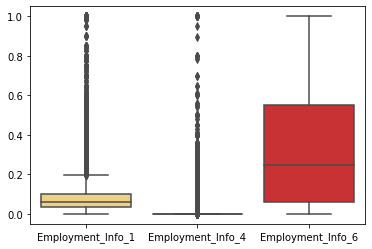

In [14]:
sns.boxplot(data = con1, palette='YlOrRd')

> Density plot 은 평균, 표준 편차 및 첨도와 같은 통계 지표를 포함하여 분포의 특성을 시각화하는 데 도움이 된다. 또한 반응 변수와 어떤 관계가 있는지 시각적으로 확인할 수 있다. 예를 들면 다음과 같다. 고용형태 6번 변수의 밀도분포표는 반응 변수의 히스토그램과 유사하며, 이는 아마도 이 변수가 반응 변수의 좋은 예측 변수가 될 수 있음을 나타낸다.



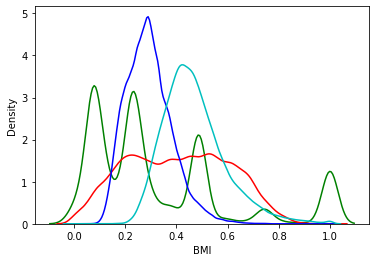

In [15]:
sns.distplot(con['Product_Info_4'], kde=True, hist=False, color='g') #dataframe만든 후 하는 것과의 차이점 
sns.distplot(con['Ins_Age'], kde=True, hist=False, color='r')
sns.distplot(con['Wt'], kde=True, hist=False, color='b')
sns.distplot(con['BMI'], kde=True, hist=False, color='c')


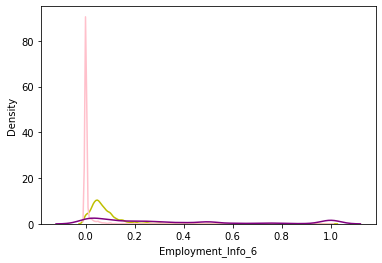

In [16]:
sns.distplot(con1['Employment_Info_1'], kde=True, hist=False, color='y') 
sns.distplot(con1['Employment_Info_4'], kde=True, hist=False, color='pink')
sns.distplot(con1['Employment_Info_6'], kde=True, hist=False, color='purple')

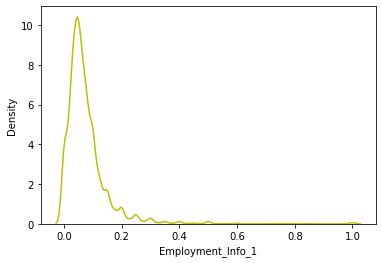

In [17]:
sns.distplot(con1['Employment_Info_1'], kde=True, hist=False, color='y') # density가 다른 경우, 표를 함께 그리려면? 

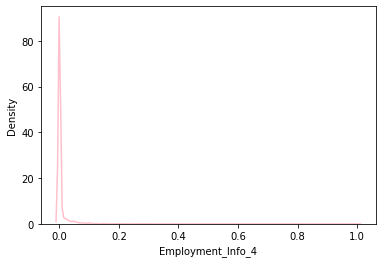

In [18]:
sns.distplot(con1['Employment_Info_4'], kde=True, hist=False, color='pink')

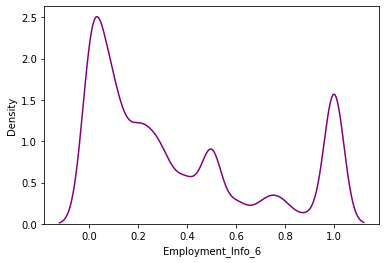

In [19]:
sns.distplot(con1['Employment_Info_6'], kde=True, hist=False, color='purple')

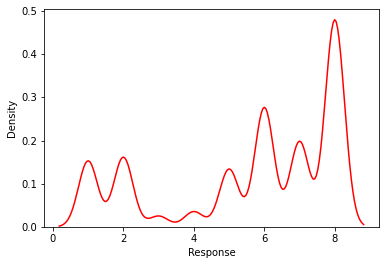

In [20]:
sns.distplot(train['Response'], kde=True, hist=False, color='red')

* 결측값 분석    

In [21]:
for i in range(1,128):
    if train.isna().sum()[i] > 0:
        print(train.columns[i], ':', train.isna().sum()[i])

Employment_Info_1 : 19
Employment_Info_4 : 6779
Employment_Info_6 : 10854
Insurance_History_5 : 25396
Family_Hist_2 : 28656
Family_Hist_3 : 34241
Family_Hist_4 : 19184
Family_Hist_5 : 41811
Medical_History_1 : 8889
Medical_History_10 : 58824
Medical_History_15 : 44596
Medical_History_24 : 55580
Medical_History_32 : 58274


In [22]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in train.columns:
        dtype = str(train[col].dtype)    # types? 
        types.append(dtype)
    tt['Types'] = types
    return tt

In [23]:
missing_data(train)['Percent'].sort_values(ascending=False)

Medical_History_10   99.06
Medical_History_32   98.14
Medical_History_24   93.60
Medical_History_15   75.10
Family_Hist_5        70.41
                      ... 
Medical_Keyword_12    0.00
Medical_Keyword_13    0.00
Medical_Keyword_14    0.00
Medical_Keyword_15    0.00
Id                    0.00
Name: Percent, Length: 128, dtype: float64

In [49]:
train=train[train.columns[train.isnull().mean() <= 0.75]]

In [25]:
train.isnull().sum().sort_values(ascending=False)

Family_Hist_5          41811
Family_Hist_3          34241
Family_Hist_2          28656
Insurance_History_5    25396
Family_Hist_4          19184
                       ...  
Medical_Keyword_13         0
Medical_Keyword_14         0
Medical_Keyword_15         0
Medical_Keyword_16         0
Id                         0
Length: 124, dtype: int64

In [26]:
for i in range(1,124):
    if train.isna().sum()[i] > 0:
        print(train.columns[i], ':', train.isna().sum()[i])

Employment_Info_1 : 19
Employment_Info_4 : 6779
Employment_Info_6 : 10854
Insurance_History_5 : 25396
Family_Hist_2 : 28656
Family_Hist_3 : 34241
Family_Hist_4 : 19184
Family_Hist_5 : 41811
Medical_History_1 : 8889


In [27]:
 list_train = train.columns[train.isna().any()].tolist() #any()

In [28]:
for i in range(0,len(list_train)):
    print('column name: ',list_train[i],' Dtype:',train[list_train[i]].dtypes) #컬럼의 갯수 

column name:  Employment_Info_1  Dtype: float64
column name:  Employment_Info_4  Dtype: float64
column name:  Employment_Info_6  Dtype: float64
column name:  Insurance_History_5  Dtype: float64
column name:  Family_Hist_2  Dtype: float64
column name:  Family_Hist_3  Dtype: float64
column name:  Family_Hist_4  Dtype: float64
column name:  Family_Hist_5  Dtype: float64
column name:  Medical_History_1  Dtype: float64


In [29]:
for column in list_train:
    train[column].fillna(train[column].mean(), inplace=True)   # R subset 기능?

In [30]:
#train.iloc[:, 2:8].isna().sum()
#train.iloc[:, 9:12].isna().sum()
#train.iloc[:, 18:24].isna().sum()
#train.iloc[:, 71:118].isna().sum() # loc로 컬럼 추출하기? 

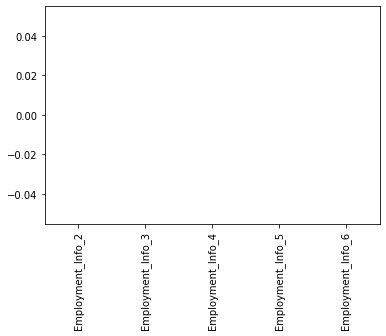

In [31]:
Employ = train.iloc[:, 13:18].isna().sum()/59381
Employ.plot(kind='bar')

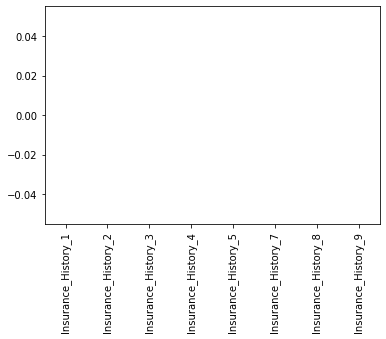

In [32]:
Insurance = train.iloc[:, 25:33].isna().sum()/59381
Insurance.plot(kind='bar')

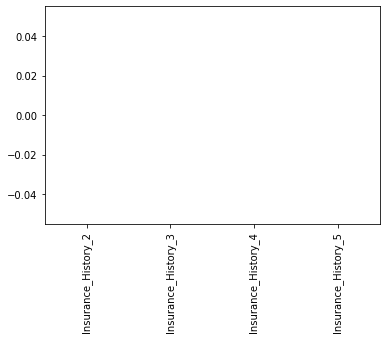

In [33]:
Family = train.iloc[:, 26:30].isna().sum()/59381
Family.plot(kind='bar')

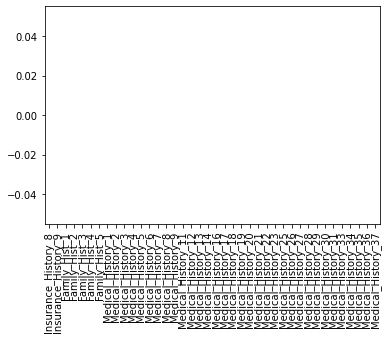

In [34]:
Medical = train.iloc[:, 31:71].isna().sum()/59381
Medical.plot(kind='bar')



> 결측값 백분율 차트는 변수가 예측을 위한 데이터 레코드가 충분한지 여부를 평가한다. 이 도표는 각 변수의 결측치의 백분율을 나타낸다.



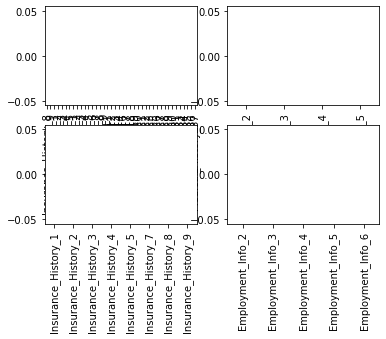

In [35]:
plt.subplot(2,2,1)
Medical.plot(kind='bar')
plt.subplot(2,2,2)
Family.plot(kind='bar')
plt.subplot(2,2,3)
Insurance.plot(kind='bar')
plt.subplot(2,2,4)
Employ.plot(kind='bar')

In [36]:
train.groupby('Response')['Employment_Info_4'].count()

Response
1     6207
2     6552
3     1013
4     1428
5     5432
6    11233
7     8027
8    19489
Name: Employment_Info_4, dtype: int64

> 이 차트를 통해 결측값 비율이 높은 변수가 반응 변수 예측에 실제로 도움이 되는지 확인할 수 있다. 각 반응 범주에 대한 결측값 분포는 변수 내에 유지되므로 결측값은 본질적으로 무작위하다.



* 사고 발생률 차트 
  

In [37]:
#train.iloc[:, 2:8]
#train.iloc[:, 9:12]
#train.iloc[:, 18:24]
#train.iloc[:, 71:118]
#train.iloc[:, 31:71]
#train.iloc[:, 26:30]
#train.iloc[:, 25:33]
#train.iloc[:, 13:18]

In [38]:
Employ_corr = train.groupby('Response')['Employment_Info_1','Employment_Info_2', 'Employment_Info_3', 'Employment_Info_4', 'Employment_Info_5', 'Employment_Info_6']

* 상관관계표
데이터 분석과 데이터 처리 후, 모델 개발 단계는 변수 감소일 것이다.

#4. 변수 처리       
 

* 누락된 데이터 처리         
데이터 처리의 예비 단계로, 결측값 비율이 높은 변수는 제거된다. 제거 임계값은 사용자가 결정하는 것이지만, 이 분석에서의 임계값은 30% 이다.            
 

* 결측값 처리      
이전 모델링 단계에서 삭제되지 않은 변수의 경우, 더 낮은 백분율의 결측값이 있는 변수에 귀속한다. 귀속에 사용되는 방법론은 나머지 데이터의 중위수를 사용하는 것이다. 이는 일반적으로 사용되는 관행이며 모든 변수에 대한 결측 데이터가 반응 변수 위에 랜덤하게 분포되기 때문에 효율적이다.

* 주성분 분석


* Boruta Classification Algorithm     
Boruta는 연관성 있는 모든 특징 선택 wrapper algorithmn 이다. 이 방법은 원래 속성의 중요성과 무작위로 시행된 중요도를 비교하여 모든 관련있는 특징에 대하여 top-down 방식으로 수행된다. 관련성이 높은 특징 순서대로 복사본을 만들고, 관련 없는 특징들을 점진적으로 제거한다. 주성분 분석 이후의 모든 속성은 알고리즘에 의해 중요한 것으로 간주된다.

#5. 방법론

* Multinominal Logic Model      
 데이터를 두 부분으로 나누고 한 부분으로 모델을 예측하고 다른 부분은 모델 유효성 검사와 표본예측을 위해 사용한다.        







> Train data 와 Test data 의 반응 분포를 살펴본다.



> Train & Test data의 분포 비교         
분포는 두 부분에 대해 동일하므로 두 부분이 유사한 분포를 따른다고 가정한다.

> Performance Metrics       
Multinominal Logic Model의 Kappa score 는 0.3183794 이다.

* Random Forest        
 데이터를 두 부분으로 나누고 한 부분을 사용하여 모델을 예측하고 다른 부분은 모델 유효성 검사와 표본 예측을 위해 사용한다. 전체 데이터 세트를 예측에 사용할 것이다.        
 

> Train data 와 Test data 의 반응 분포를 살펴본다.



> Train & Test data의 분포 비교         
 분포는 두 부분에 대해 동일하므로 두 부분이 유사한 분포를 따른다고 가정한다.    

> Performance Metrics           
 Random Forest의 Kappa Score는 0.4744071이다.           
Random Forest 예측에 사용되는 Rattel plot(or tree) 은 다음과 같다.

* XGBoost            
XGBoost는 "Extreme Gradient Boosting"의 줄임말로, 여기서 "Gradient Boosting"이라는 용어는 Greedy function approximation 논문에서 제안했다 : Gradient Boosting machine, by Friedman.       
XGBoost는 이 original model 을 기반으로 한다. XGBoost는 학습 문제를 관라하는 데 자주 사용되는데, training data(with multiple features, xi)를 사용하여 target variable(yi)을 예측하는데 사용된다.